# Static Word Embedding

Pre-trained large language models including BERT can have limitations for the research purpose of extracting semantic meaning and comparing cross-document similarity. Li et al. (2020) point out BERT's anistropic characteristic results in underperformance in sentence similarity compared to GloVe embeddings. They further point out that the last layer of BERT is not appropriate for similarity metrics, given their non-smoothing characteristic. Non-smoothing nature of BERT model implies that the mapping on embedding space is not consistent across documents and sentences, making it perform poorly to generate semantic comparison. 

Glove (Pennington et al., 2014) is a static pre-trained model based on Wikipedia sources. It is static, compared to BERT, in that it is not contextualized to a specific document given. GloVe model is based on the global (referring to statistics of the entire corpus) co-occurrence matrix and moving skip-gram. 

In [5]:
import gensim
from gensim import utils
import numpy as np
import pandas as pd
import os
import time
import spacy 
import scipy
from spacy import displacy
import gensim.downloader as api



# Read the input DataFrame
df = pd.read_csv('../../../data/processed/cleaned.csv')

# Create the output folder if it doesn't exist
output_folder = "../../../output/embedding_static/word2vec"
os.makedirs(output_folder, exist_ok=True)

start_time = time.time()

# Static Embedding with Word2Vec Pre-Trained model

In [3]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')


# Load the input DataFrame
df = pd.read_csv('../../../data/processed/cleaned.csv')

# Tokenize the text data and filter out stopwords
stop_words = set(stopwords.words('english'))

sentences = []
for text in df['text']: 
    words = [word.lower() for word in word_tokenize(text) if word.isalpha() and word.lower() not in stop_words]
    sentences.append(words)

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the trained model
output_folder = "../../../output/embedding_static/word2vec"
os.makedirs(output_folder, exist_ok=True)
model_path = os.path.join(output_folder, "word2vec_model.bin")
model.save(model_path)

# Convert the Word2Vec model to GloVe format
word_vectors = model.wv
word_vectors.save_word2vec_format(os.path.join(output_folder, 'glove_vectors.txt'), binary=False)

print("GloVe word embeddings generated and saved successfully.")


RuntimeError: Compiled extensions are unavailable. If you've installed from a package, ask the package maintainer to include compiled extensions. If you're building Gensim from source yourself, install Cython and a C compiler, and then run `python setup.py build_ext --inplace` to retry. 

# Static Embedding by GloVe pre-trained model

In [7]:
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity


# Load embeddings
glove = api.load("glove-wiki-gigaword-100")

# Load the input DataFrame
df = pd.read_csv('../../../data/processed/cleaned.csv')

# Create the output folder if it doesn't exist
output_folder = "../../../output/embedding_glove"
os.makedirs(output_folder, exist_ok=True)

# Load sentences
sentences = df['text'].tolist()

# Tokenize and filter sentences
sentences = [[word for word in sentence.lower().split() if word in glove] for sentence in sentences]

# Compute sentence embeddings
embeddings = []
for sentence in sentences:
    emb = np.mean([glove[word] for word in sentence], axis=0)
    embeddings.append(emb)

# Export embeddings
np.savetxt(os.path.join(output_folder, "static_embedding.csv"), embeddings, delimiter=",")


In [9]:
keyword1 = "sovereignty"
keyword2 = "territory"

if keyword1 in glove.key_to_index and keyword2 in glove.key_to_index:
    # Get embeddings for the keywords
    embedding1 = glove[keyword1].reshape(1, -1)
    embedding2 = glove[keyword2].reshape(1, -1)

    # Compute cosine similarity between embeddings for each row (speech document)
    similarities = []
    for text in df['text']:
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)
        similarity = cosine_similarity(embedding1, emb)[0][0]
        similarities.append(similarity)

    # Add similarities to DataFrame
    df['similarity_to_sovereignty'] = similarities

    # Save the DataFrame
    output_folder = "../../../output/similarity_over_time"
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, "similarity_to_sovereignty.csv")
    df.to_csv(output_path, index=False)
    
    print(f"Similarity between '{keyword1}' and '{keyword2}' computed over time and saved successfully.")
else:
    print("One or both of the keywords are not in the vocabulary.")


Similarity between 'sovereignty' and 'territory' computed over time and saved successfully.


In [19]:
import matplotlib.pyplot as plt

# Check if keywords are in the vocabulary
keyword1 = "sovereignty"
keyword2 = "territory"

if keyword1 in glove.key_to_index and keyword2 in glove.key_to_index:
    # Get embeddings for the keywords
    embedding1 = glove[keyword1].reshape(1, -1)
    embedding2 = glove[keyword2].reshape(1, -1)

    # Compute cosine distance (1 - cosine similarity) between embeddings for each row
    distances_democracy = []
    distances_non_democracy = []
    for text, democracy in zip(df['text'], df['democracy']):
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)
        distance = np.linalg.norm(embedding1 - emb)  # Calculate L2 distance
        if democracy == 'Democracy':
            distances_democracy.append(distance)
        else:
            distances_non_democracy.append(distance)

    # Visualize distance over time with dot plot for democracy regime
    plt.figure(figsize=(10, 5))
    plt.scatter(df[df['democracy'] == 'Democracy']['year'], distances_democracy)
    plt.xlabel('Year')
    plt.ylabel('Distance')
    plt.title('Change in Distance between "Territory" and "Sovereignty" over Time (Democracy)')
    plt.grid(True)
    plt.show()

    # Visualize distance over time with dot plot for non-democracy regime
    plt.figure(figsize=(10, 5))
    plt.scatter(df[df['democracy'] == 'Non-Democracy']['year'], distances_non_democracy)
    plt.xlabel('Year')
    plt.ylabel('Distance')
    plt.title('Change in Distance between "Territory" and "Sovereignty" over Time (Non-Democracy)')
    plt.grid(True)
    plt.show()

    print("Visualizations completed successfully.")
else:
    print("One or both of the keywords are not in the vocabulary.")


KeyError: 'democracy'

## I also use vdem's polyarchy score as a category. 

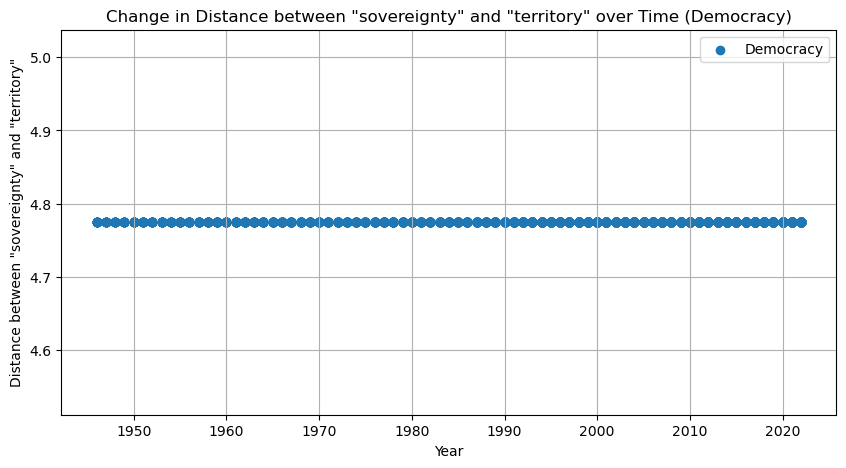

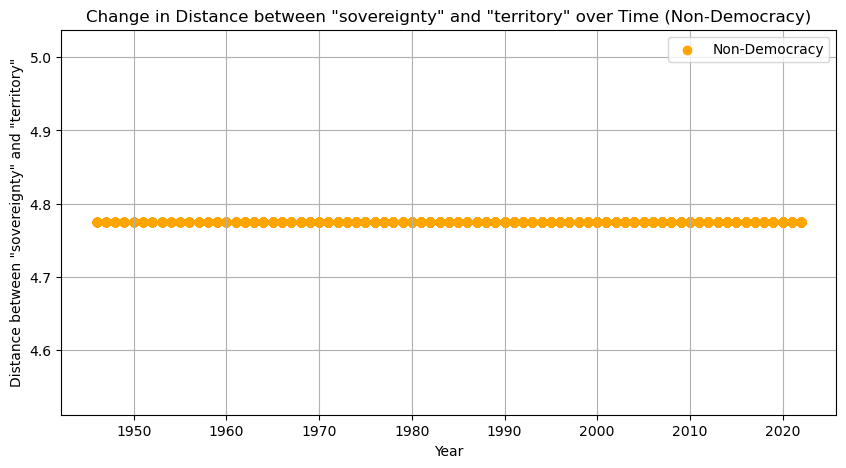

Visualizations completed successfully.


In [16]:
import matplotlib.pyplot as plt

# Define keyword parameters
keyword1 = "sovereignty"
keyword2 = "territory"

if keyword1 in glove.key_to_index and keyword2 in glove.key_to_index:
    # Compute distance for democracy regime
    distances_democracy = []
    for text in democracy_df['text']:
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)  # Corrected line
        distance = np.linalg.norm(glove[keyword1].reshape(1, -1) - glove[keyword2].reshape(1, -1))  # Calculate L2 distance
        distances_democracy.append(distance)

    # Compute distance for non-democracy regime
    distances_non_democracy = []
    for text in non_democracy_df['text']:
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)  # Corrected line
        distance = np.linalg.norm(glove[keyword1].reshape(1, -1) - glove[keyword2].reshape(1, -1))  # Calculate L2 distance
        distances_non_democracy.append(distance)

    # Plotting distance over time for democracy regime
    plt.figure(figsize=(10, 5))
    plt.scatter(democracy_df['year'], distances_democracy, label='Democracy')
    plt.xlabel('Year')
    plt.ylabel('Distance between "sovereignty" and "territory"')
    plt.title('Change in Distance between "sovereignty" and "territory" over Time (Democracy)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plotting the distance over time for non-democracy regime
    plt.figure(figsize=(10, 5))
    plt.scatter(non_democracy_df['year'], distances_non_democracy, label='Non-Democracy', color='orange')
    plt.xlabel('Year')
    plt.ylabel('Distance between "sovereignty" and "territory"')
    plt.title('Change in Distance between "sovereignty" and "territory" over Time (Non-Democracy)')
    plt.grid(True)
    plt.legend()
    plt.show()

    print("Visualizations completed successfully.")
else:
    print("One or both of the keywords are not in the vocabulary.")


# Additional experiments

In [9]:
import numpy as np
import pandas as pd
import os
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load GloVe embeddings
glove = api.load("glove-wiki-gigaword-100")

# Load the input DataFrame
df = pd.read_csv('../../../data/processed/cleaned.csv')  # adjust the path as necessary

# Check if keywords are in the vocabulary
keyword1 = "israel"
keyword2 = "palesti"

if keyword1 in glove.key_to_index and keyword2 in glove.key_to_index:
    # Get embeddings for the keywords
    embedding1 = glove[keyword1].reshape(1, -1)
    embedding2 = glove[keyword2].reshape(1, -1)

    # Compute cosine similarity between embeddings for each row
    similarities = []
    for text in df['text']:
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)
        similarity = cosine_similarity(embedding1, emb)[0][0]
        similarities.append(similarity)

    # Add similarities to DataFrame
    df['similarity_to_sovereignty'] = similarities

    # Visualize similarity over time
    plt.plot(df['year'], df['similarity_to_sovereignty'])
    plt.xlabel('Year')
    plt.ylabel('Similarity to "sovereignty"')
    plt.title('Change in Similarity to "sovereignty" over Time')
    plt.grid(True)
    plt.show()
    
    print("Visualization completed successfully.")
else:
    print("One or both of the keywords are not in the vocabulary.")


One or both of the keywords are not in the vocabulary.


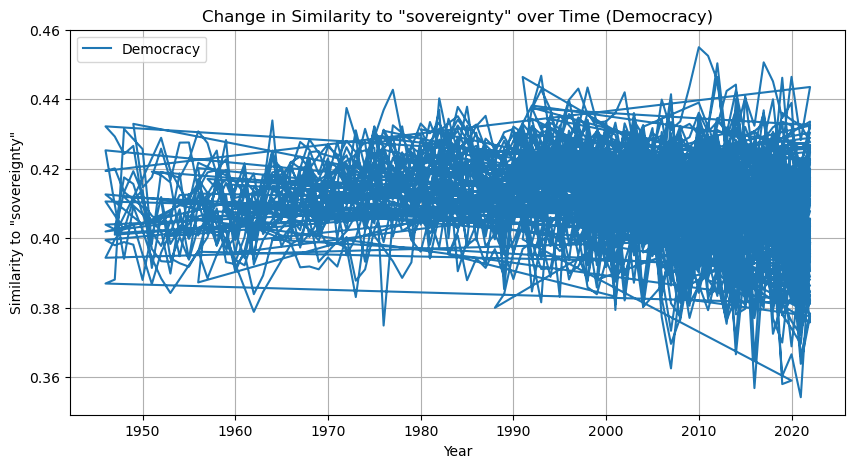

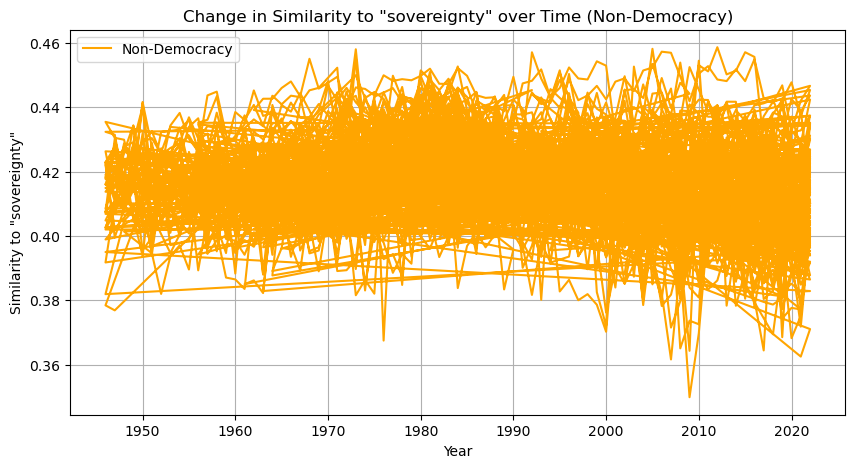

Visualizations completed successfully.


In [10]:

# Load the input data
df = pd.read_csv('../../../data/processed/meta.csv')  # meta data contains country-year variables

# define keyword parameters
keyword1 = "territorial"
keyword2 = "colonial"

if keyword1 in glove.key_to_index and keyword2 in glove.key_to_index:
    # Generate new variable based on v2x_polyarchy
    df['regime_type'] = np.where(df['v2x_polyarchy'] >= 0.5, 'Democracy', 'Non-Democracy')

    # Filter DataFrame by regime type
    democracy_df = df[df['regime_type'] == 'Democracy']
    non_democracy_df = df[df['regime_type'] == 'Non-Democracy']

    # Compute similarity for democracy regime
    similarities_democracy = []
    for text in democracy_df['text']:
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)
        similarity = cosine_similarity(glove[keyword1].reshape(1, -1), emb)[0][0]
        similarities_democracy.append(similarity)

    # Compute similarity for non-democracy regime
    similarities_non_democracy = []
    for text in non_democracy_df['text']:
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)
        similarity = cosine_similarity(glove[keyword1].reshape(1, -1), emb)[0][0]
        similarities_non_democracy.append(similarity)

    # Plotting similarity over time for democracy regime
    plt.figure(figsize=(10, 5))
    plt.plot(democracy_df['year'], similarities_democracy, label='Democracy')
    plt.xlabel('Year')
    plt.ylabel('Similarity to "sovereignty"')
    plt.title('Change in Similarity to "sovereignty" over Time (Democracy)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plotting the similarity over time for non-democracy regime
    plt.figure(figsize=(10, 5))
    plt.plot(non_democracy_df['year'], similarities_non_democracy, label='Non-Democracy', color='orange')
    plt.xlabel('Year')
    plt.ylabel('Similarity to "sovereignty"')
    plt.title('Change in Similarity to "sovereignty" over Time (Non-Democracy)')
    plt.grid(True)
    plt.legend()
    plt.show()

    print("Visualizations completed successfully.")
else:
    print("One or both of the keywords are not in the vocabulary.")


# Baseline variation across documents

I compute the statistics of the embedding scores (mean and cosine similarity) for each year and plot them as a histogram.

The glove.key_to_index function  maps each unique word to a unique index. If a word appears multiple times in the corpus, it will still be mapped to the same index.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load the input data
df = pd.read_csv('../../../data/processed/meta.csv')  # meta data contains country-year variables


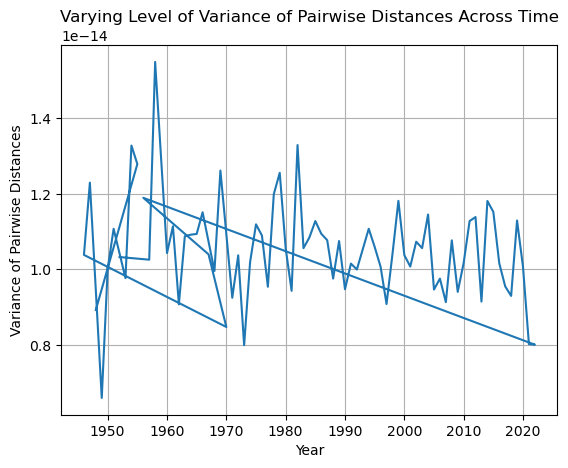

In [14]:

# Initialize variables to store results
years = []
variances = []

# Iterate over each year
for year in df['year'].unique():
    # Filter data for the current year
    year_data = df[df['year'] == year]
    
    # Compute pairwise similarities
    similarities = []
    for text in year_data['text']:
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)
        similarity = cosine_similarity(emb, emb)[0][0]  # Compare each word to the average embedding of all words
        similarities.append(similarity)
    
    # Calculate variance of pairwise distances
    variance = np.var(similarities)
    
    # Append year and variance to the lists
    years.append(year)
    variances.append(variance)

# Plot variance of pairwise distances across years
plt.plot(years, variances)
plt.ylabel('Variance of Pairwise Distances')
plt.xlabel('Year')
plt.title('Varying Level of Variance of Pairwise Distances Across Time')
plt.grid(True)
plt.show()

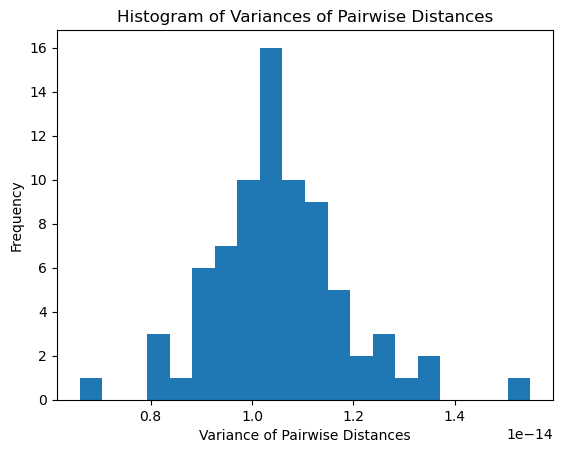

In [12]:

# Initialize variables to store results
variances = []

# Iterate over each year
for year in df['year'].unique():
    # Filter data for the current year
    year_data = df[df['year'] == year]
    
    # Compute pairwise similarities
    similarities = []
    for text in year_data['text']:
        words = text.lower().split()
        emb = np.mean([glove[word] for word in words if word in glove.key_to_index], axis=0)
        emb = emb.reshape(1, -1)
        similarity = cosine_similarity(emb, emb)[0][0]  # Compare each word to the average embedding of all words
        similarities.append(similarity)
    
    # Calculate variance of pairwise distances
    variance = np.var(similarities)
    variances.append(variance)

# Plot histogram of variances
plt.hist(variances, bins=20)
plt.xlabel('Variance of Pairwise Distances')
plt.ylabel('Frequency')
plt.title('Histogram of Variances of Pairwise Distances')
plt.show()

## checking whether the same word gets same numeric embedding value. 

In [18]:

# Check if the word "right" exists in the vocabulary
import gensim.downloader

# Load GloVe embeddings
glove = gensim.downloader.load('glove-wiki-gigaword-300')

if "right" in glove.key_to_index:
    # Get the embedding vector for the word "right"
    embedding_1 = glove["right"]
    print("Embedding vector for the first occurrence of 'right':", embedding_1)

    # Get the embedding vector for another occurrence of the word "right"
    # You can replace the text below with another occurrence of the word "right" in your corpus
    text_with_right = "The right answer is the correct one."
    words_with_right = text_with_right.lower().split()
    embedding_2 = glove["right"]
    print("Embedding vector for another occurrence of 'right':", embedding_2)

    # Check if the embedding vectors are the same
    if (embedding_1 == embedding_2).all():
        print("The embedding vectors for 'right' are the same.")
    else:
        print("The embedding vectors for 'right' are different.")
else:
    print("The word 'right' is not in the vocabulary.")

Embedding vector for the first occurrence of 'right': [ 7.5965e-02 -2.9300e-01 -3.1477e-01  1.3020e-01 -1.2990e-01 -4.8191e-02
 -4.2748e-01 -3.0292e-01 -4.2468e-02 -1.6282e+00 -1.6107e-01 -3.4765e-01
 -5.1817e-02 -2.0463e-01 -1.6552e-01  8.6603e-01 -3.6746e-01  5.8860e-01
  2.4732e-01  4.4265e-01  1.6044e-02  5.0401e-01  6.6919e-01 -6.3785e-01
 -4.5476e-01  2.1259e-01  1.1329e-02 -5.7080e-02 -3.3795e-01  9.9728e-02
  1.2073e-01  3.3822e-01  1.5927e-01 -2.3315e-01 -1.3418e+00 -1.4019e-01
  1.8814e-01 -2.8651e-01 -4.1570e-01  2.8131e-01  2.5345e-01  1.3318e-01
  7.4970e-02 -5.1506e-01 -3.2919e-02 -8.0107e-02  3.9156e-01  6.7576e-02
  4.6271e-02  4.1506e-01 -1.5066e-01 -2.7747e-01  4.1766e-01 -2.8443e-01
 -2.7563e-01 -1.3113e-01  5.1671e-01  2.4617e-03 -1.7877e-01  4.4989e-01
  1.9761e-02 -1.8702e-01 -5.9143e-01  2.1533e-01 -4.1413e-01 -6.2623e-01
  3.7717e-01 -1.0003e-01  1.6393e-01 -6.5906e-02  5.3771e-01 -2.0366e-01
 -1.0336e-01  5.3027e-01  2.6753e-01 -3.6144e-01  1.5471e-01 -4.1722e-